# KAGGLE ÜZERİNDEN VERİLERİMİZİ YÜKLÜYORUZ

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("quadeer15sh/augmented-forest-segmentation")

print("Path to dataset files:", path)

100%|██████████| 172M/172M [00:09<00:00, 18.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2


data_path = /root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest Segmented/Forest Segmented

# VERİLERİMİZİ YÜKLEDİKTEN SONRA GEREKLİ KÜTÜPHANERLERİ İMPORT EDİYORUZ

In [2]:
# Import libraries

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator

from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

# META_DATA.CSV DOSYASI ÜZERİNDEN VERİLERİMİZE GÖZ ATIYORUZ

In [3]:
df = pd.read_csv("/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/Forest_Segmented/meta_data.csv")

In [4]:
df.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


# VERİLERİMİZDE BİR EKSİKLİK VEYA HATA VAR MI DİYE KONTROL EDİYOR VE GÖRSELLEŞTİRİYORUZ

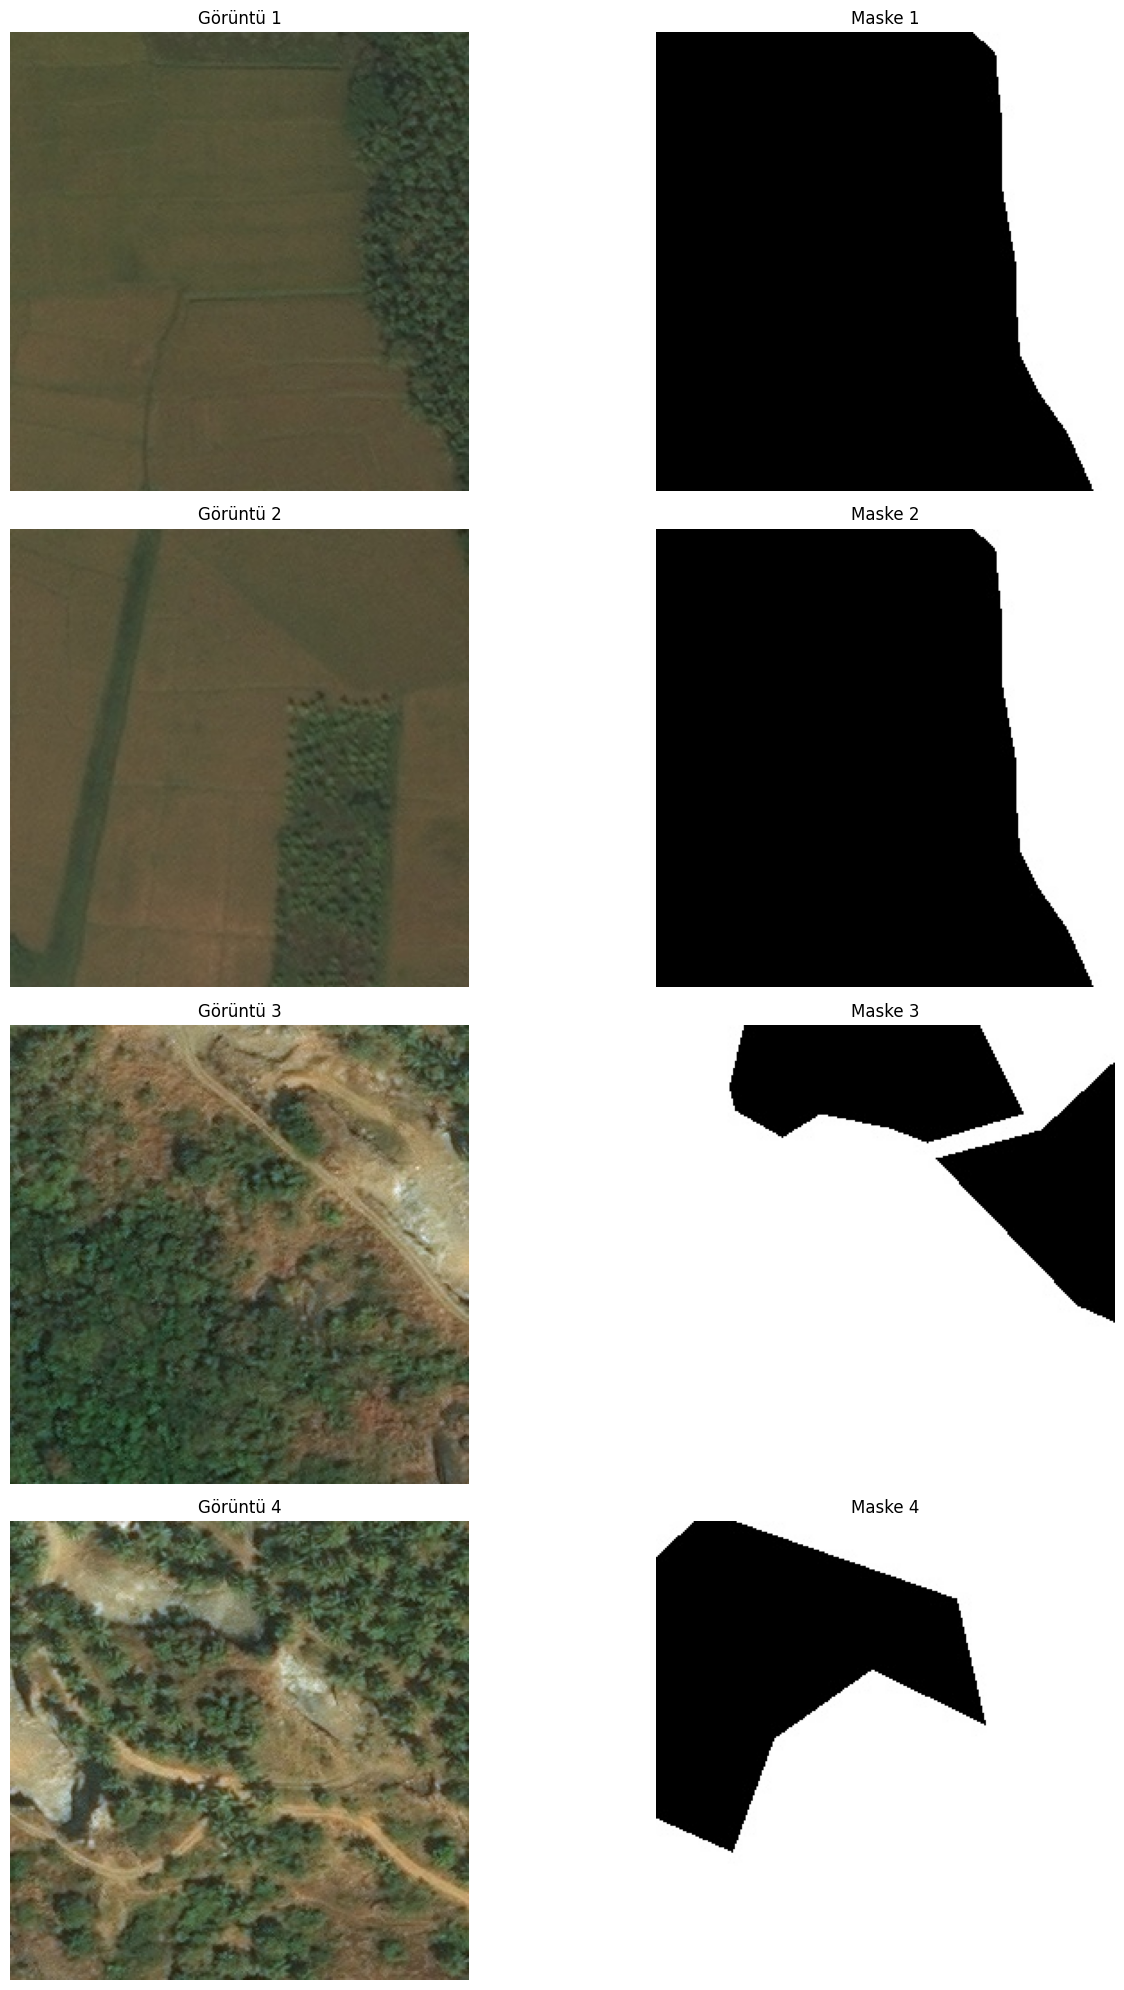

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Görüntü okumak için
import os # Bu durumda os.path.basename gibi fonksiyonlar için hala gerekli olabilir

# Kendi ayırdığınız yollar bunlar
images_path = [
    "/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/Forest_Segmented/images/10452_sat_08.jpg",
    "/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/Forest_Segmented/images/10452_sat_18.jpg",
    "/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/Forest_Segmented/images/111335_sat_00.jpg",
    "/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/Forest_Segmented/images/111335_sat_01.jpg"
]

masks_path = [
    "/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/Forest_Segmented/masks/10452_mask_08.jpg",
    "/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/Forest_Segmented/masks/10452_mask_08.jpg",
    "/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/Forest_Segmented/masks/111335_mask_00.jpg",
    "/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/Forest_Segmented/masks/111335_mask_01.jpg",
]



num_samples = len(images_path) # Göstereceğimiz örnek sayısı (görüntü listesinin boyutu)

plt.figure(figsize=(15, num_samples * 5)) # Şeklin genel boyutunu ayarlayın (her resim çifti için biraz daha yer)

# Görüntü ve maske yolları listeleri üzerinden döngü
for i in range(num_samples):
    image_file_path = images_path[i]
    mask_file_path = masks_path[i]

    # Görüntüleri oku
    try:
        image = mpimg.imread(image_file_path)
        mask = mpimg.imread(mask_file_path)
    except FileNotFoundError:
        print(f"Hata: Dosya bulunamadı. Lütfen '{image_file_path}' veya '{mask_file_path}' yollarının doğru olduğunu kontrol edin.")
        continue # Sonraki resme geç

    # Görüntüyü göster
    plt.subplot(num_samples, 2, 2*i + 1) # (Toplam Satır, Sütun, Mevcut Konum)
    plt.imshow(image)
    plt.title(f'Görüntü {i+1}')
    plt.axis('off') # Eksenleri gizle

    # Maskeyi göster
    plt.subplot(num_samples, 2, 2*i + 2)
    # Maske tek kanallı (gri tonlamalı) olacağı için cmap='gray' kullanmak iyidir.
    # Eğer maske 3 kanallı okunursa (örneğin JPG olduğu için), gri tonlamalı görünmesi için ilk kanalı seçin.
    if mask.ndim == 3: # Eğer maske 3 kanallı ise (RGB gibi)
        plt.imshow(mask[:, :, 0], cmap='gray') # İlk kanalı gri tonlamalı olarak göster
    else: # Zaten tek kanallı ise
        plt.imshow(mask, cmap='gray')
    plt.title(f'Maske {i+1}')
    plt.axis('off') # Eksenleri gizle

plt.tight_layout() # Alt grafikler arasındaki boşluğu otomatik ayarla
plt.show() # Grafiği göster

# VERİ TEK BİR DOSYADAN OLUŞTUĞU İÇİN ÖNCE DOSYALARI TRAİN,TEST,VAL OLARAK AYIRIYORUZ

In [6]:

import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# # --- 1. Yapılandırma Ayarları ---
DATASET_ROOT_PATH = '/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/Forest_Segmented'
ORIGINAL_IMAGES_PATH = os.path.join(DATASET_ROOT_PATH, 'images')
ORIGINAL_MASKS_PATH = os.path.join(DATASET_ROOT_PATH, 'masks')

NEW_DATASET_OUTPUT_DIR = 'processed_forest_dataset'

TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1

RANDOM_STATE = 42

# # --- 2. Yeni Klasör Yapısını Oluşturma ---
print(f"'{NEW_DATASET_OUTPUT_DIR}' klasör yapısı oluşturuluyor...")
for subset in ['train', 'val', 'test']:
     os.makedirs(os.path.join(NEW_DATASET_OUTPUT_DIR, subset, 'images'), exist_ok=True)
     os.makedirs(os.path.join(NEW_DATASET_OUTPUT_DIR, subset, 'masks'), exist_ok=True)
print("Klasörler başarıyla oluşturuldu.")

# # --- 3. Görüntü ve Maske Dosya Yollarını Toplama ---
print("Görüntü ve maske dosyaları taranıyor...")
all_image_filenames = sorted(os.listdir(ORIGINAL_IMAGES_PATH))
all_mask_filenames = sorted(os.listdir(ORIGINAL_MASKS_PATH))

all_images = [os.path.join(ORIGINAL_IMAGES_PATH, fname) for fname in all_image_filenames]
all_masks = [os.path.join(ORIGINAL_MASKS_PATH, fname) for fname in all_mask_filenames]

if len(all_images) != len(all_masks):
     print("UYARI: Görüntü ve maske dosyası sayıları eşleşmiyor!")

print(f"Toplam {len(all_images)} görüntü ve {len(all_masks)} maske dosyası bulundu.")

# # --- 4. Veriyi Eğitim, Doğrulama ve Test Olarak Ayırma ---
print("Veri setleri ayrılıyor...")

X_train, X_temp, y_train, y_temp = train_test_split(
     all_images, all_masks, test_size=(VAL_SIZE + TEST_SIZE), random_state=RANDOM_STATE
)

val_test_ratio = TEST_SIZE / (VAL_SIZE + TEST_SIZE)
X_val, X_test, y_val, y_test = train_test_split(
     X_temp, y_temp, test_size=val_test_ratio, random_state=RANDOM_STATE
)

print(f"Eğitim seti boyutu: {len(X_train)} görüntü")
print(f"Doğrulama seti boyutu: {len(X_val)} görüntü")
print(f"Test seti boyutu: {len(X_test)} görüntü")

# # --- 5. Dosyaları Yeni Klasör Yapısına Kopyalama ---
print("\nDosyalar yeni klasörlere kopyalanıyor...")

def copy_files_to_subset(image_list, mask_list, subset_name):
     for img_path, msk_path in tqdm(zip(image_list, mask_list), total=len(image_list), desc=f"Kopyalanıyor: {subset_name}"):
         img_filename = os.path.basename(img_path)
         msk_filename = os.path.basename(msk_path)

         dest_img_path = os.path.join(NEW_DATASET_OUTPUT_DIR, subset_name, 'images', img_filename)
         dest_msk_path = os.path.join(NEW_DATASET_OUTPUT_DIR, subset_name, 'masks', msk_filename)

         shutil.copyfile(img_path, dest_img_path)
         shutil.copyfile(msk_path, dest_msk_path)

copy_files_to_subset(X_train, y_train, 'train')
copy_files_to_subset(X_val, y_val, 'val')
copy_files_to_subset(X_test, y_test, 'test')

print("\nTüm dosyalar başarıyla kopyalandı ve veri seti ayrıldı!")
print(f"Yeni veri seti klasörünüz: '{NEW_DATASET_OUTPUT_DIR}'")


'processed_forest_dataset' klasör yapısı oluşturuluyor...
Klasörler başarıyla oluşturuldu.
Görüntü ve maske dosyaları taranıyor...
Toplam 5108 görüntü ve 5108 maske dosyası bulundu.
Veri setleri ayrılıyor...
Eğitim seti boyutu: 4086 görüntü
Doğrulama seti boyutu: 511 görüntü
Test seti boyutu: 511 görüntü

Dosyalar yeni klasörlere kopyalanıyor...


Kopyalanıyor: test: 100%|██████████| 511/511 [00:00<00:00, 4204.17it/s]


Tüm dosyalar başarıyla kopyalandı ve veri seti ayrıldı!
Yeni veri seti klasörünüz: 'processed_forest_dataset'


new_data_path = /content/processed_forest_dataset


# VERİ ARTTIRMA

In [7]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_gen = ImageDataGenerator(
    rescale =1./255
)

train_data_images = data_gen.flow_from_directory(
    "/content/processed_forest_dataset/train/",
    target_size=(256, 256),
    classes=["images"],
    batch_size=16,
    color_mode='rgb',
    class_mode=None,
    seed=42,
    shuffle = True
)
train_data_masks = data_gen.flow_from_directory(
    "/content/processed_forest_dataset/train/",
    target_size=(256, 256),
    classes=["masks"],
    batch_size=16,
    color_mode='grayscale',
    class_mode=None,
    seed=42,
    shuffle = True
)

val_data_images = val_test_gen.flow_from_directory(
    "/content/processed_forest_dataset/val/",
    target_size=(256, 256),
    classes=["images"],
    batch_size=16,
    color_mode='rgb',
    class_mode=None,
    seed=42
)
val_data_masks = val_test_gen.flow_from_directory(
    "/content/processed_forest_dataset/val/",
    target_size=(256, 256),
    classes=["masks"],
    batch_size=16,
    color_mode='grayscale',
    class_mode=None,
    seed=42
)

test_data_images = val_test_gen.flow_from_directory(
    "/content/processed_forest_dataset/test/",
    target_size=(256, 256),
    classes=["images"],
    batch_size=16,
    color_mode='rgb',
    class_mode=None,
    seed=42
)
test_data_masks = val_test_gen.flow_from_directory(
    "/content/processed_forest_dataset/test/",
    target_size=(256, 256),
    classes=["masks"],
    batch_size=16,
    color_mode='grayscale',
    class_mode=None,
    seed=42
)


Found 4086 images belonging to 1 classes.
Found 4086 images belonging to 1 classes.
Found 511 images belonging to 1 classes.
Found 511 images belonging to 1 classes.
Found 511 images belonging to 1 classes.
Found 511 images belonging to 1 classes.


# U-NET MODEL KURULUMU

In [9]:
import os

# BU SATIRI, diğer TENSORFLOW veya SEGMENTATION_MODELS import'larından ÖNCE koyun.
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.models import Model
backbone='resnet34'

try:
    model = sm.Unet(
        backbone_name=backbone,
        encoder_weights='imagenet',
        input_shape=(256,256,3),
        classes=1,

        activation='sigmoid'
    )

    print(model.summary())

except Exception as e:
    print("hata: ", e)

print(f"\nU-Net modeli '{backbone}' omurgasıyla başarıyla oluşturuldu.")

Segmentation Models: using `tf.keras` framework.
85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

None

U-Net modeli 'resnet34' omurgasıyla başarıyla oluşturuldu.


# MODEL DERLEMESİ VE EĞİTİM

In [10]:
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.models import Model

loss_function = sm.losses.bce_jaccard_loss
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metrics = [
    sm.metrics.iou_score,   # Intersection over Union (IoU) skorunu hesaplar
    sm.metrics.f1_score,
    tf.keras.metrics.BinaryAccuracy()
]

model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

print("\nModel Başarıyla Derlendi")


Model Başarıyla Derlendi


In [11]:
import numpy as np
import tensorflow as tf

# --- Görüntü ve Maske Generator'larını Birleştirme Fonksiyonu ---
def combine_generators(img_gen, msk_gen):
    while True:
        img_batch = next(img_gen)
        msk_batch = next(msk_gen)

        # Maskeleri ikili hale getir ve float32'ye dönüştür
        msk_batch = np.where(msk_batch > 0.5, 1.0, 0.0).astype(np.float32)

        yield img_batch, msk_batch

# Veri generatorlarını tanımladığınız boyutlar ve batch boyutu
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
NUM_CHANNELS = 3 # Görüntüler için 3 kanal (RGB)
MASK_CHANNELS = 1 # Maskeler için 1 kanal (gri tonlama)

# Birleştirilmiş Generator'ları tf.data.Dataset'e dönüştürme
# Bu kısım hatayı çözmek için anahtar!
# output_signature ile generator'dan beklenen veri tipini ve şeklini belirtiyoruz.
train_generator_dataset = tf.data.Dataset.from_generator(
    lambda: combine_generators(train_data_images, train_data_masks),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), dtype=tf.float32), # Görüntüler
        tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, MASK_CHANNELS), dtype=tf.float32)  # Maskeler
    )
).prefetch(tf.data.AUTOTUNE) # Veri yüklemesini optimize et

val_generator_dataset = tf.data.Dataset.from_generator(
    lambda: combine_generators(val_data_images, val_data_masks),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, MASK_CHANNELS), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE) # Veri yüklemesini optimize et

# Eğitim Parametreleri
EPOCHS = 20
STEPS_PER_EPOCH = train_data_images.samples // BATCH_SIZE
VALIDATION_STEPS = val_data_images.samples // BATCH_SIZE

if STEPS_PER_EPOCH == 0:
    STEPS_PER_EPOCH = 1
if VALIDATION_STEPS == 0:
    VALIDATION_STEPS = 1

print(f"\nEğitim başlıyor... Toplam {EPOCHS} epoch.")
print(f"Her epoch için adım sayısı (steps_per_epoch): {STEPS_PER_EPOCH}")
print(f"Doğrulama adımı sayısı (validation_steps): {VALIDATION_STEPS}")

# --- Model Eğitimi ---
history = model.fit(
    train_generator_dataset,  # Artık tf.data.Dataset'i kullanıyoruz
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=val_generator_dataset, # Artık tf.data.Dataset'i kullanıyoruz
    validation_steps=VALIDATION_STEPS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ModelCheckpoint('unet_forest_segmentation.h5', save_best_only=True, monitor='val_loss', verbose=1)
    ]
)

print("\nModel eğitimi tamamlandı! 🎉")


Eğitim başlıyor... Toplam 20 epoch.
Her epoch için adım sayısı (steps_per_epoch): 255
Doğrulama adımı sayısı (validation_steps): 31
Epoch 1/20
123/255 ━━━━━━━━━━━━━━━━━━━━ 53s 403ms/step - binary_accuracy: 0.6817 - f1-score: 0.6516 - iou_score: 0.4887 - loss: 1.0966

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - binary_accuracy: 0.7262 - f1-score: 0.6948 - iou_score: 0.5391 - loss: 0.9982
Epoch 1: val_loss improved from inf to 4.04314, saving model to unet_forest_segmentation.h5


255/255 ━━━━━━━━━━━━━━━━━━━━ 171s 435ms/step - binary_accuracy: 0.7264 - f1-score: 0.6951 - iou_score: 0.5394 - loss: 0.9977 - val_binary_accuracy: 0.3840 - val_f1-score: 0.0460 - val_iou_score: 0.0236 - val_loss: 4.0431
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - binary_accuracy: 0.8216 - f1-score: 0.8068 - iou_score: 0.6776 - loss: 0.7388
Epoch 2: val_loss improved from 4.04314 to 3.75761, saving model to unet_forest_segmentation.h5


255/255 ━━━━━━━━━━━━━━━━━━━━ 140s 456ms/step - binary_accuracy: 0.8216 - f1-score: 0.8069 - iou_score: 0.6776 - loss: 0.7388 - val_binary_accuracy: 0.3887 - val_f1-score: 0.0353 - val_iou_score: 0.0180 - val_loss: 3.7576
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - binary_accuracy: 0.5936 - f1-score: 0.6397 - iou_score: 0.4733 - loss: 1.3304
Epoch 3: val_loss improved from 3.75761 to 1.82241, saving model to unet_forest_segmentation.h5


255/255 ━━━━━━━━━━━━━━━━━━━━ 137s 539ms/step - binary_accuracy: 0.5936 - f1-score: 0.6397 - iou_score: 0.4733 - loss: 1.3301 - val_binary_accuracy: 0.6088 - val_f1-score: 0.7284 - val_iou_score: 0.5754 - val_loss: 1.8224
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - binary_accuracy: 0.7441 - f1-score: 0.7475 - iou_score: 0.6021 - loss: 0.9200
Epoch 4: val_loss did not improve from 1.82241
255/255 ━━━━━━━━━━━━━━━━━━━━ 103s 406ms/step - binary_accuracy: 0.7443 - f1-score: 0.7477 - iou_score: 0.6023 - loss: 0.9195 - val_binary_accuracy: 0.3869 - val_f1-score: 0.1791 - val_iou_score: 0.0988 - val_loss: 2.5475
Epoch 5/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - binary_accuracy: 0.8288 - f1-score: 0.8198 - iou_score: 0.6964 - loss: 0.7099
Epoch 5: val_loss improved from 1.82241 to 0.77069, saving model to unet_forest_segmentation.h5


255/255 ━━━━━━━━━━━━━━━━━━━━ 147s 577ms/step - binary_accuracy: 0.8288 - f1-score: 0.8199 - iou_score: 0.6964 - loss: 0.7099 - val_binary_accuracy: 0.8036 - val_f1-score: 0.7944 - val_iou_score: 0.6609 - val_loss: 0.7707
Epoch 6/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - binary_accuracy: 0.8347 - f1-score: 0.8264 - iou_score: 0.7055 - loss: 0.6874
Epoch 6: val_loss did not improve from 0.77069
255/255 ━━━━━━━━━━━━━━━━━━━━ 102s 399ms/step - binary_accuracy: 0.8347 - f1-score: 0.8264 - iou_score: 0.7056 - loss: 0.6873 - val_binary_accuracy: 0.8012 - val_f1-score: 0.7916 - val_iou_score: 0.6567 - val_loss: 0.7890
Epoch 7/20
 27/255 ━━━━━━━━━━━━━━━━━━━━ 1:25 377ms/step - binary_accuracy: 0.8204 - f1-score: 0.8258 - iou_score: 0.7051 - loss: 0.7279

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - binary_accuracy: 0.8414 - f1-score: 0.8360 - iou_score: 0.7200 - loss: 0.6653
Epoch 7: val_loss improved from 0.77069 to 0.69777, saving model to unet_forest_segmentation.h5


255/255 ━━━━━━━━━━━━━━━━━━━━ 112s 441ms/step - binary_accuracy: 0.8414 - f1-score: 0.8361 - iou_score: 0.7200 - loss: 0.6653 - val_binary_accuracy: 0.8334 - val_f1-score: 0.8229 - val_iou_score: 0.7007 - val_loss: 0.6978
Epoch 8/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - binary_accuracy: 0.8554 - f1-score: 0.8460 - iou_score: 0.7347 - loss: 0.6277
Epoch 8: val_loss did not improve from 0.69777
255/255 ━━━━━━━━━━━━━━━━━━━━ 135s 529ms/step - binary_accuracy: 0.8554 - f1-score: 0.8461 - iou_score: 0.7347 - loss: 0.6277 - val_binary_accuracy: 0.8156 - val_f1-score: 0.8013 - val_iou_score: 0.6706 - val_loss: 0.7494
Epoch 9/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - binary_accuracy: 0.8614 - f1-score: 0.8539 - iou_score: 0.7465 - loss: 0.6010
Epoch 9: val_loss did not improve from 0.69777
255/255 ━━━━━━━━━━━━━━━━━━━━ 96s 376ms/step - binary_accuracy: 0.8614 - f1-score: 0.8539 - iou_score: 0.7465 - loss: 0.6010 - val_binary_accuracy: 0.8247 - val_f1-score: 0.8252 - val_iou_score: 0.

# MODELİMİZİ KAYDEDELİM

In [13]:
model.save("unet_forest_segmentation_end.keras")